In [113]:
# some standard python imports #
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import MAS_library as MASL
import smoothing_library as SL
import math
from astropy.stats import sigma_clipped_stats
from tqdm import tqdm
from scipy.spatial import KDTree


In [9]:
def inttopair(n, num_columns):
    row = n // num_columns
    col = n % num_columns
    return row, col

In [83]:
def singledist(curpos,pos,it):
    dist_list=[]
    for i in pos:
        tempdist=np.sqrt(((curpos[0]-i[0])**2)+((curpos[1]-i[1])**2)+((curpos[1]-i[1])**2))
        dist_list.append(tempdist)

    dist_list.sort()
    singdist=dist_list[it-1]

    return singdist
    

In [167]:
def distsorter(df, low, high, col, delta_g, delta):
    para=df[col]
    condition = (df[col] >= low) & (df[col] < high)
    rows=df[condition].index
    newdf= df.loc[rows]
    newpos = newdf.loc[:,['x','y','z']].to_numpy(dtype=np.float32)
    oldpos= df.loc[:,['x','y','z']].to_numpy(dtype=np.float32)
    
    newdist=newdf.loc[:,["3rd_Distance"]].to_numpy(dtype=np.float32)
    
    new_delta_g=[]
    new_delta=[]
    for i in newpos:
        x=int(round(i[0]))
        y=int(round(i[1]))
        z=int(round(i[2]))
        
        tempdelg=delta_g[x][y][z]
        tempdel=delta[x][y][z]
        
        new_delta_g.append(tempdelg)
        new_delta.append(tempdel)

        
    tempb = (np.array(new_delta_g)/np.array(new_delta)).flatten()
    return tempb, newdist

In [68]:
def magsorter(df, low, high, col, delta_g, delta):
    para=df[col]
    condition = (df[col] >= low) & (df[col] < high)
    rows=df[condition].index
    newdf= df.loc[rows]
    newpos = newdf.loc[:,['x','y','z']].to_numpy(dtype=np.float32)
    oldpos= df.loc[:,['x','y','z']].to_numpy(dtype=np.float32)
    
    newmag=newdf.loc[:,['K_Mag']].to_numpy(dtype=np.float32)
    
    new_delta_g=[]
    new_delta=[]
    for i in newpos:
        x=int(round(i[0]))
        y=int(round(i[1]))
        z=int(round(i[2]))
        
        tempdelg=delta_g[x][y][z]
        tempdel=delta[x][y][z]
        
        new_delta_g.append(tempdelg)
        new_delta.append(tempdel)

        
    tempb = (np.array(new_delta_g)/np.array(new_delta)).flatten()
    return tempb, newmag

In [208]:
def combb(df, delta_g, delta):
    newpos = df.loc[:,['x','y','z']].to_numpy(dtype=np.float32)
    
    new_delta_g=[]
    new_delta=[]
    for i in newpos:
        x=int(round(i[0]))
        y=int(round(i[1]))
        z=int(round(i[2]))
        
        tempdelg=delta_g[x][y][z]
        tempdel=delta[x][y][z]
        
        new_delta_g.append(tempdelg)
        new_delta.append(tempdel)

        
    tempb = (np.array(new_delta_g)/np.array(new_delta)).flatten()
    return tempb, np.array(new_delta_g), np.array(new_delta)

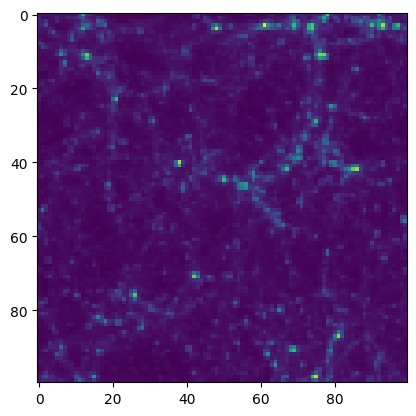

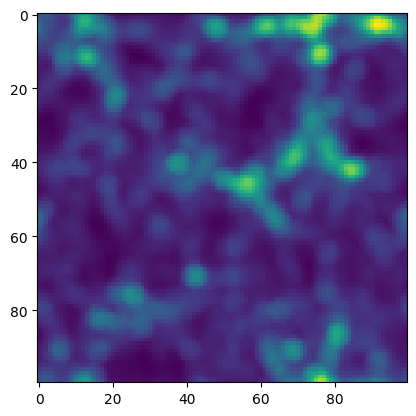

              id  desc_id        pid          Mvir      Rvir       rs  \
0      115038658       -1         -1  3.778000e+14  1468.342  173.826   
1      115117999       -1         -1  2.484000e+14  1276.745  308.091   
2      115038666       -1  115038658  1.495000e+14  1078.016  173.103   
3      115039716       -1         -1  1.300000e+14  1028.897  199.351   
4      115039166       -1         -1  9.669000e+13   932.276  230.178   
...          ...      ...        ...           ...       ...      ...   
46750  115324977       -1  115325023  1.957000e+10    54.733    1.357   
46751  115325270       -1  115325272  1.957000e+10    54.733    2.536   
46752  115327418       -1  115327419  1.957000e+10    54.733    1.149   
46753  115329082       -1  115329081  1.957000e+10    54.733    1.470   
46754  115329477       -1  115329476  1.957000e+10    54.733    3.619   

          vmax         x          y         z  ...       vz     Spin  \
0      1273.96  30.39950   46.35684  43.28916  ... 

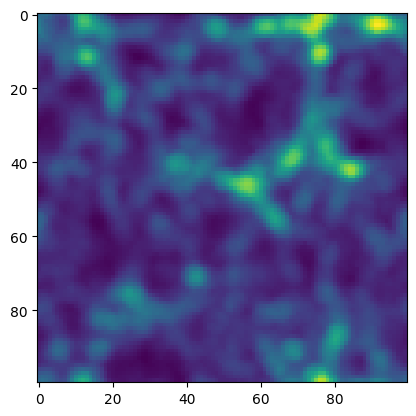

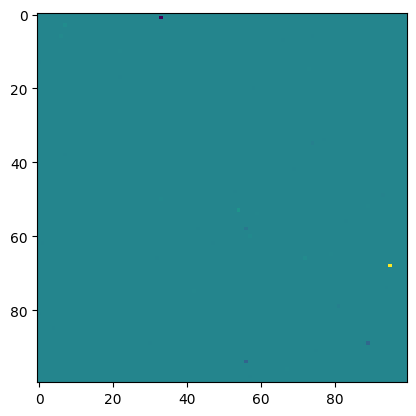

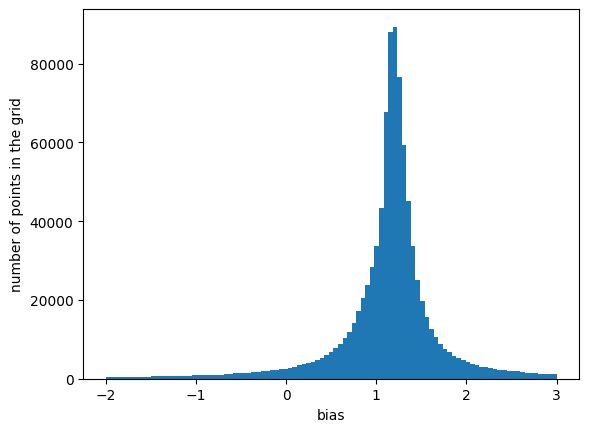

In [14]:

##Read in the snapshot data 

snapshot = 'snapshot_500'          #name of Gadget file
ptypes = [1]                       #this specifies that the simulation only contains dark matter particles
grid = 100                         #this is how you specify the size of your density grid (I just made it 100x100)
MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
do_RSD   = False                   #don't do redshift-space distortions (https://en.wikipedia.org/wiki/Redshift-space_distortions)
axis     = 0                       #axis along which to place RSD; not used here
verbose  = False                   #whether to print information on the progress


# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

#Quick Check
plt.imshow(np.mean(delta,axis=0)) #plot the density field
plt.show()

BoxSize = 115  #from simulation params. Mpc/h 
R = 4       #smoothing kernal in Mpc/h
grid = delta.shape[0]
Filter  = 'Top-Hat' #type of smoothing kernal 
threads = 8   #computer threads, for parallelization 

# compute FFT (fast fourier transform) of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
delta_smoothed = SL.field_smoothing(delta, W_k, threads)

#Quick Check
plt.imshow(np.mean(delta_smoothed,axis=0)) 
plt.show()


#Read in galaxy data
filename = 'galaxycat.csv'
galaxycat  = pd.read_csv(filename)
print(galaxycat)

pos = galaxycat.loc[:,['x','y','z']].to_numpy(dtype=np.float32)

#Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
delta_g = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(pos, delta_g, BoxSize, MAS, verbose=False)
delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0



# smooth the field
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
delta_g_smoothed = SL.field_smoothing(delta_g, W_k, threads)

#Quick Check
plt.imshow(np.mean(delta_g_smoothed,axis=0))
plt.show()

b = (delta_g_smoothed/delta_smoothed).flatten()

hist = plt.hist(b, bins = np.linspace(-2,3,100))
plt.xlabel('bias')
plt.ylabel('number of points in the grid')
plt.show()

In [47]:
#Read in galaxy data
filename = 'galaxycat.csv'
galaxycat  = pd.read_csv(filename)

In [209]:
##Read in the snapshot data 

snapshot = 'snapshot_500'          #name of Gadget file
ptypes = [1]                       #this specifies that the simulation only contains dark matter particles
grid = 116                         #this is how you specify the size of your density grid (I just made it 100x100) (116 to collect all galaxies)
MAS      = 'CIC'                   #Cloud-in-Cell. This is just the interpolation scheme we are using to calculate the density
do_RSD   = False                   #don't do redshift-space distortions (https://en.wikipedia.org/wiki/Redshift-space_distortions)
axis     = 0                       #axis along which to place RSD; not used here
verbose  = False                   #whether to print information on the progress


# Compute the effective number of particles/mass in each voxel
delta = MASL.density_field_gadget(snapshot, ptypes, grid, MAS, do_RSD, axis, verbose)

# compute density contrast: delta = rho/<rho> - 1
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

BoxSize = 115  #from simulation params. Mpc/h 
R = 4       #smoothing kernal in Mpc/h
grid = delta.shape[0]
Filter  = 'Top-Hat' #type of smoothing kernal 
threads = 8   #computer threads, for parallelization 

# compute FFT (fast fourier transform) of the filter
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)

# smooth the field
delta_smoothed = SL.field_smoothing(delta, W_k, threads)


pos = galaxycat.loc[:,['x','y','z']].to_numpy(dtype=np.float32)

#Get density field.  MASL.MA is filling in the values of delta_g using CIC interpolation
delta_g = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(pos, delta_g, BoxSize, MAS, verbose=False)
delta_g /= np.mean(delta_g, dtype=np.float64);  delta_g -= 1.0



# smooth the field
W_k = SL.FT_filter(BoxSize, R, grid, Filter, threads)
delta_g_smoothed = SL.field_smoothing(delta_g, W_k, threads)

all_b=(delta_g_smoothed/delta_g).flatten()

comb_b, comb_delta_g, comb_delta=combb(galaxycat, delta_g_smoothed, delta_smoothed)


# building luminosity bins
k_mag=galaxycat['K_Mag']

k_mean=k_mag.mean()
k_std=k_mag.std()

k_min=math.floor(k_mag.min())
k_max=math.ceil(k_mag.max())

# bin via half mag
size=(k_max-k_min)*2
col='K_Mag'
low=k_min
high=k_min+.5


b_list=[]
label_list=[]
mag_list=[]
for i in range(size):
    templabel=str(low)+" - "+str(high)
    tempb,tempmag=magsorter(galaxycat, low, high, col, delta_g_smoothed, delta_smoothed)
    b_list.append(tempb)
    label_list.append(templabel)
    mag_list.append(tempmag)
    low+=.5
    high+=.5


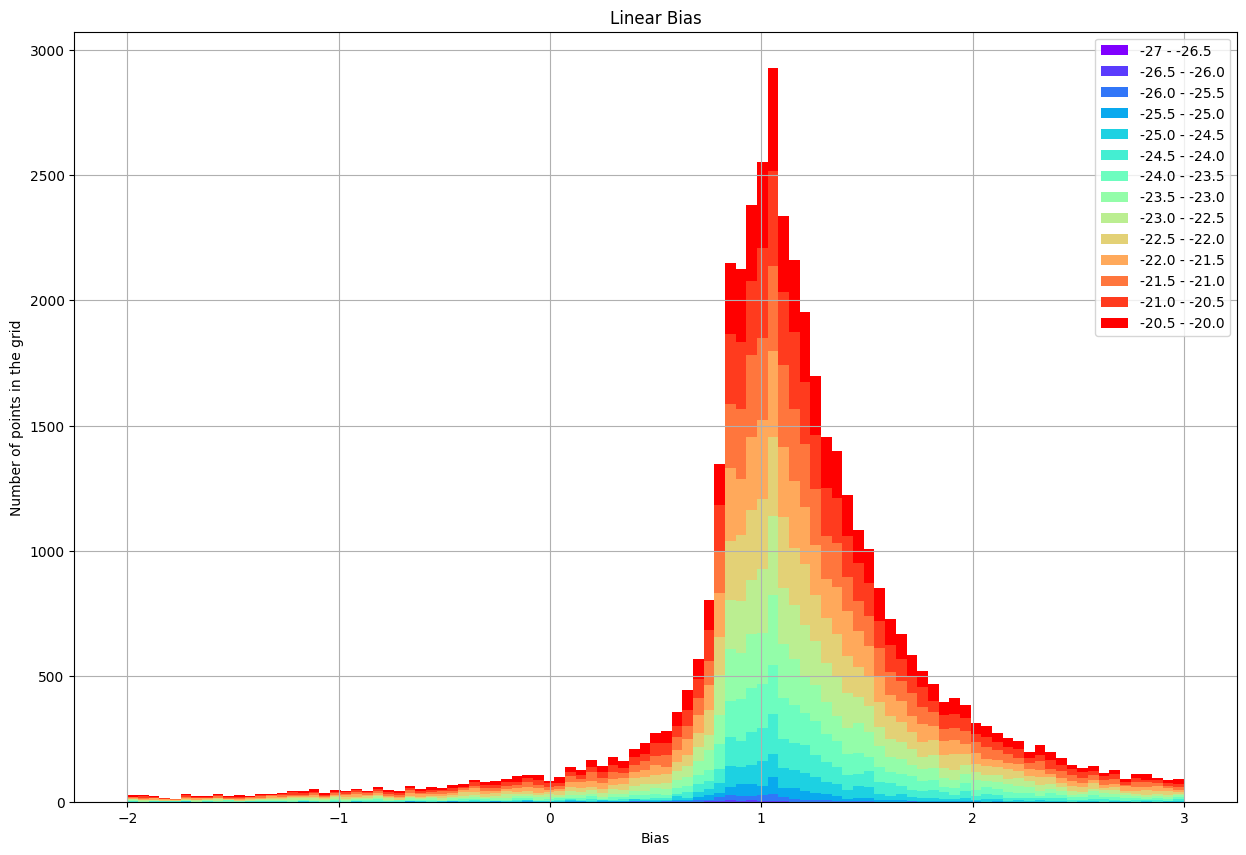

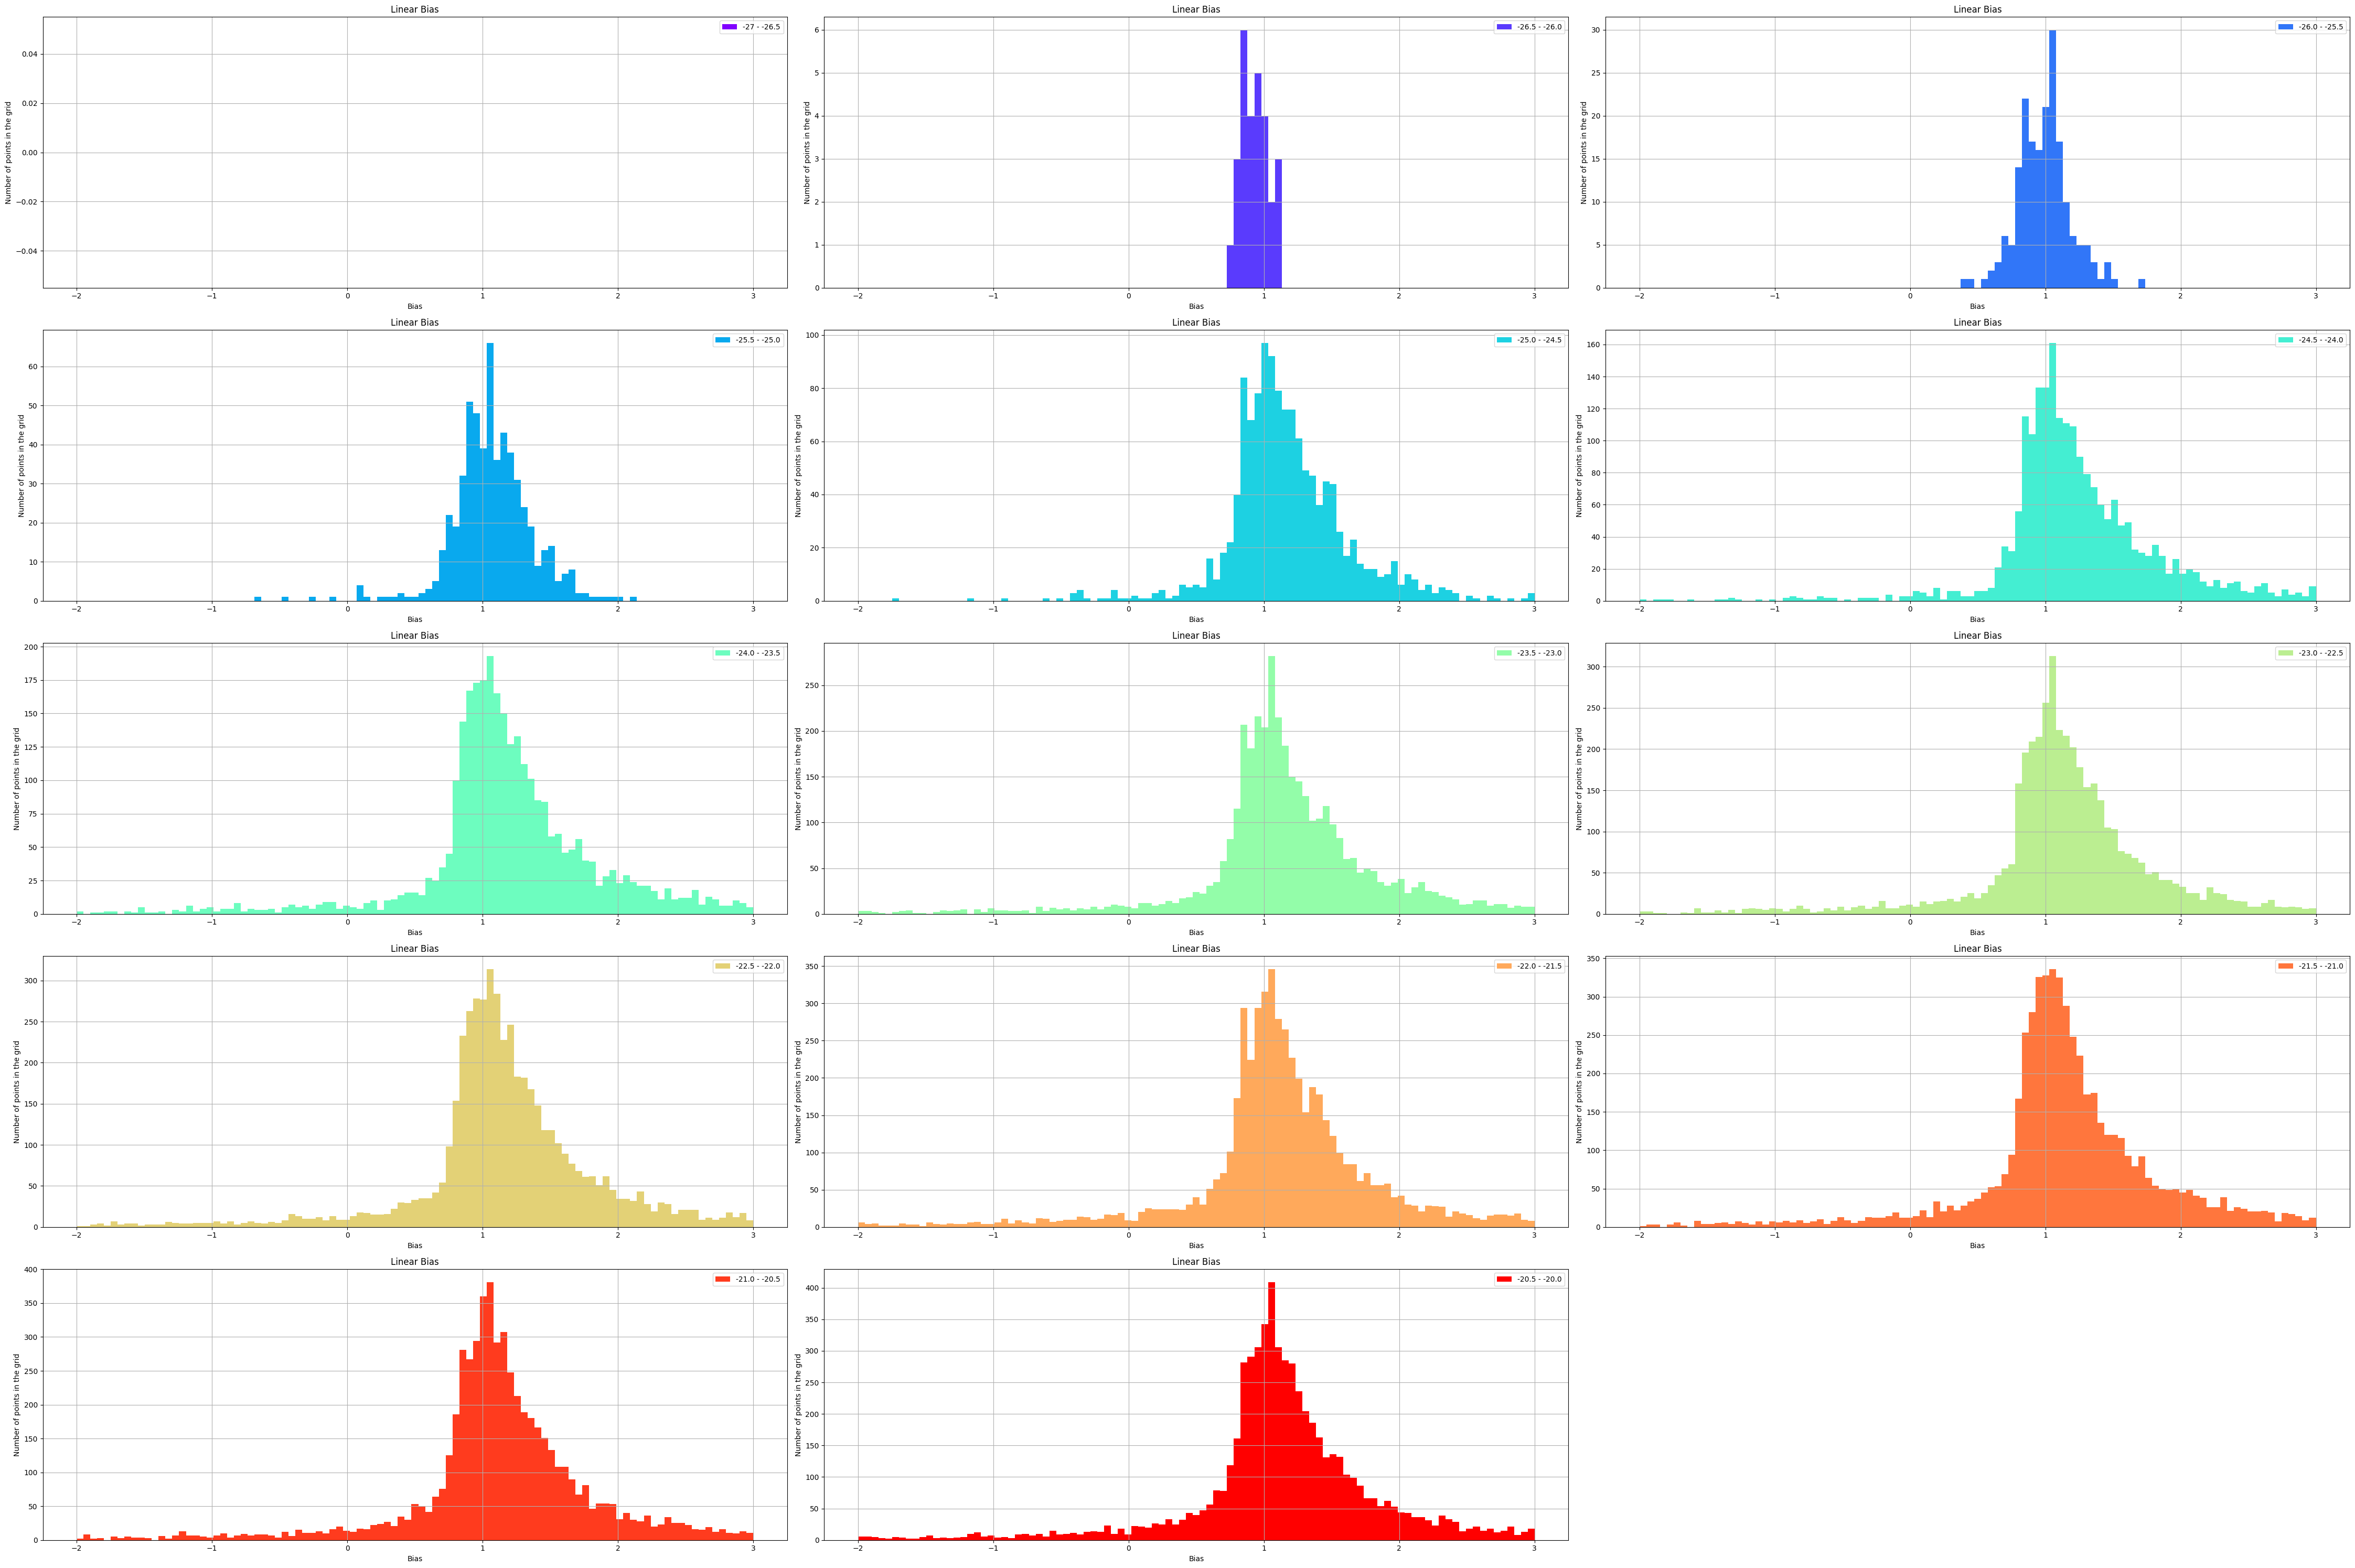

In [81]:
#label_list=[r"$<-2\sigma$",r"$-2\sigma{} - -1\sigma$",r"$-1\sigma{} - \mu$",r"$\mu{} - 1\sigma$",r"$1\sigma{} - 2\sigma$",r"$>2\sigma$"]

color_list = cm.rainbow(np.linspace(0, 1, size))


plt.figure(figsize=(15,10))
hist = plt.hist(b_list,bins = np.linspace(-2,3,100),label=label_list,stacked=True,density=False,color=color_list)
plt.legend()
plt.title('Linear Bias')
plt.xlabel('Bias')
plt.ylabel('Number of points in the grid')
plt.grid()
#plt.savefig("Bias_MagStack.png",format="png")
plt.show()

height=math.ceil(size/3)
fig =plt.figure(figsize=(45,30))
for i in range(len(b_list)):
    q,r=inttopair(i,3)
    ax = plt.subplot2grid((height, 3), (q, r), rowspan=1, colspan=1)
    
    hist = ax.hist(b_list[i], bins = np.linspace(-2,3,100),label=label_list[i],color=color_list[i])
    ax.legend()
    ax.title.set_text('Linear Bias')
    ax.set_xlabel('Bias')
    ax.set_ylabel('Number of points in the grid')
    ax.grid()

#plt.savefig("Bias_Magind.png",format="png")
plt.tight_layout()
plt.show()

In [231]:
for i in range(len(b_list)):
    mn,md,std = sigma_clipped_stats(b_list[i])
    med=np.median(b_list[i])
    print()
    print(md)
    print(med)


nan
nan

0.9215461
0.9215461

1.0051035
1.0028808

1.0593778
1.0584234

1.1154896
1.1249455

1.1614727
1.1708468

1.1445302
1.1496139

1.1261151
1.1346366

1.1319227
1.1359107

1.1359732
1.1391637

1.1140057
1.1190027

1.1242168
1.1280217

1.1211673
1.1273509

1.1252439
1.1278892


/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


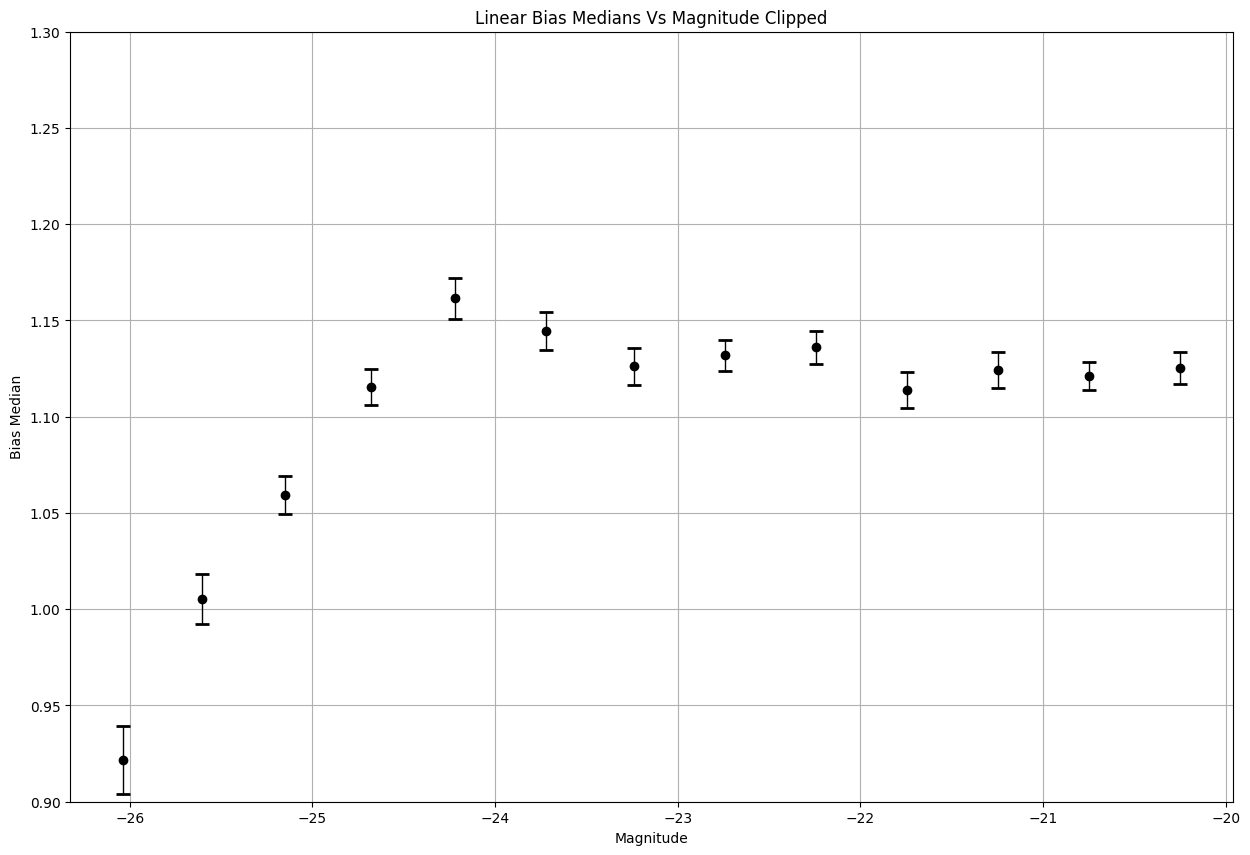

/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


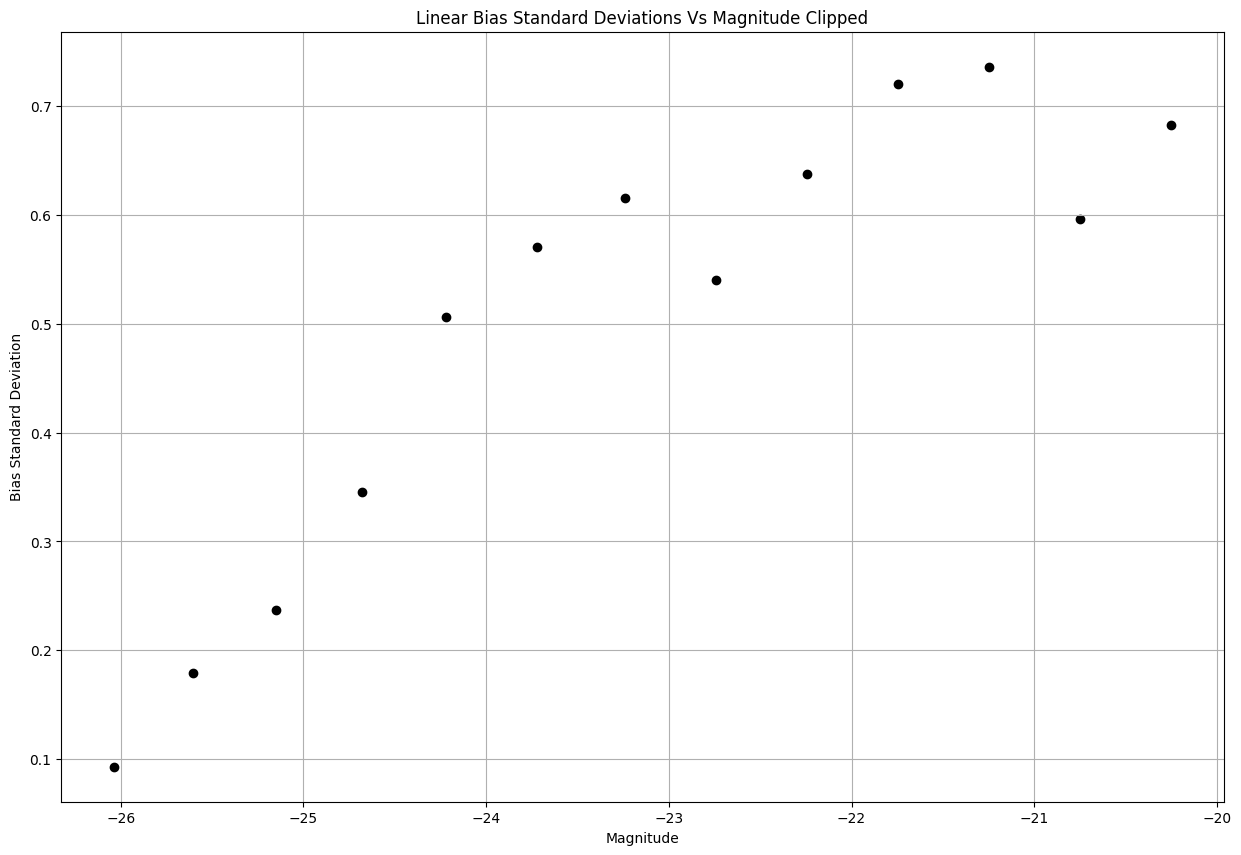

In [244]:


plt.figure(figsize=(15,10))
for i in range(len(b_list)):
    mn,md,std = sigma_clipped_stats(b_list[i])
    yerr=std/np.sqrt(len(b_list[i]))
    plt.errorbar(np.median(mag_list[i]),md, yerr=yerr,ecolor="black", capsize=5, capthick=2, elinewidth=1)
    plt.scatter(np.median(mag_list[i]),md,label=label_list[i],color="black")
plt.title('Linear Bias Medians Vs Magnitude Clipped')
plt.xlabel('Magnitude')
plt.ylabel('Bias Median')
plt.ylim(.9,1.3)
plt.grid()
plt.savefig("BiasVMagmedclipped+error.png",format="png")
plt.show()

plt.figure(figsize=(15,10))
for i in range(len(b_list)):
    mn,md,std = sigma_clipped_stats(b_list[i])
    plt.scatter(np.median(mag_list[i]),std,label=label_list[i],color="black")
plt.title('Linear Bias Standard Deviations Vs Magnitude Clipped')
plt.xlabel('Magnitude')
plt.ylabel('Bias Standard Deviation')
plt.grid()
#plt.savefig("BiasVMagstd.png",format="png")
plt.show()


In [164]:
# building distance list (NOTE distsorter in next cell requires "3rd_Distance" to be inserted into galaxycat data frame which is currently commented out)
kdtree=KDTree(pos)
threedist,points=kdtree.query(pos,3)
third_dist_list=[i[2] for i in threedist]

#galaxycat.insert(23, "3rd_Distance", third_dist_list, True)
#galaxycat["3rd_Distance"]=third_dist_list


In [254]:

# building distance bins
three=galaxycat["3rd_Distance"]

three_min=math.floor(three.min())
three_max=math.ceil(three.max())

# bin via half mag
threesize=(three_max-three_min)*2
low=three_min
high=three_min+.5


three_b_list=[]
three_dist_list=[]
label_list=[]
for i in range(threesize):
    templabel=str(low)+" - "+str(high)
    tempb,tempdist=distsorter(galaxycat, low, high, "3rd_Distance", delta_g_smoothed, delta_smoothed)
    three_b_list.append(tempb)
    three_dist_list.append(tempdist)
    label_list.append(templabel)
    low+=.5
    high+=.5

/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:1030: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


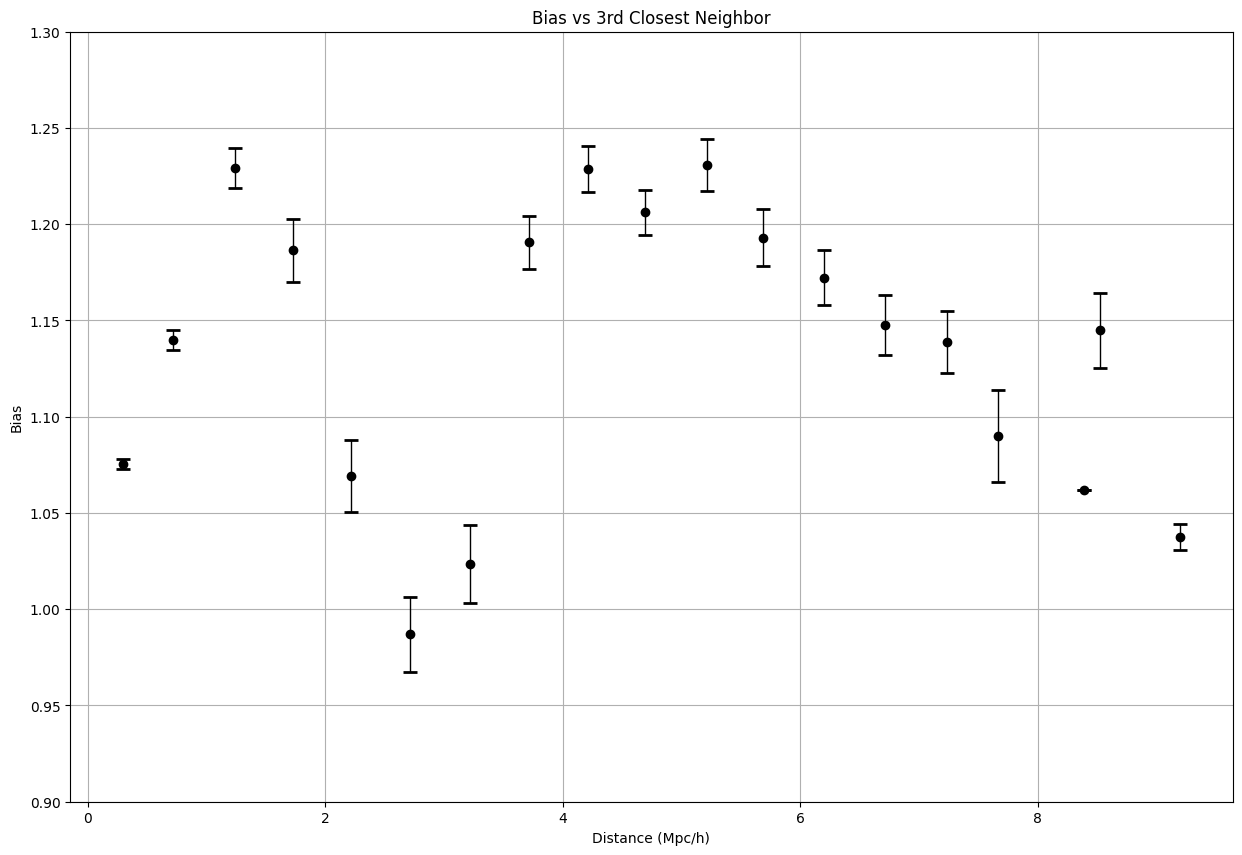

In [255]:
color_list = cm.rainbow(np.linspace(0, 1, threesize))


plt.figure(figsize=(15,10))
for i in range(len(three_b_list)):
    three_mn,three_md,three_std = sigma_clipped_stats(three_b_list[i])
    yerr=three_std/np.sqrt(len(three_b_list[i]))
    plt.errorbar(np.median(three_dist_list[i]),three_md, yerr=yerr,ecolor="black", capsize=5, capthick=2, elinewidth=1)
    plt.scatter(np.median(three_dist_list[i]),three_md,label=label_list[i],color='black')
#plt.legend()
plt.title('Bias vs 3rd Closest Neighbor')
plt.xlabel('Distance (Mpc/h)')
plt.ylabel('Bias')
plt.ylim(.9,1.3)
plt.grid()
plt.savefig("Bias_Distmedclipped+error.png",format="png")
plt.show()

/Users/ianpadgett/opt/anaconda3/envs/pv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


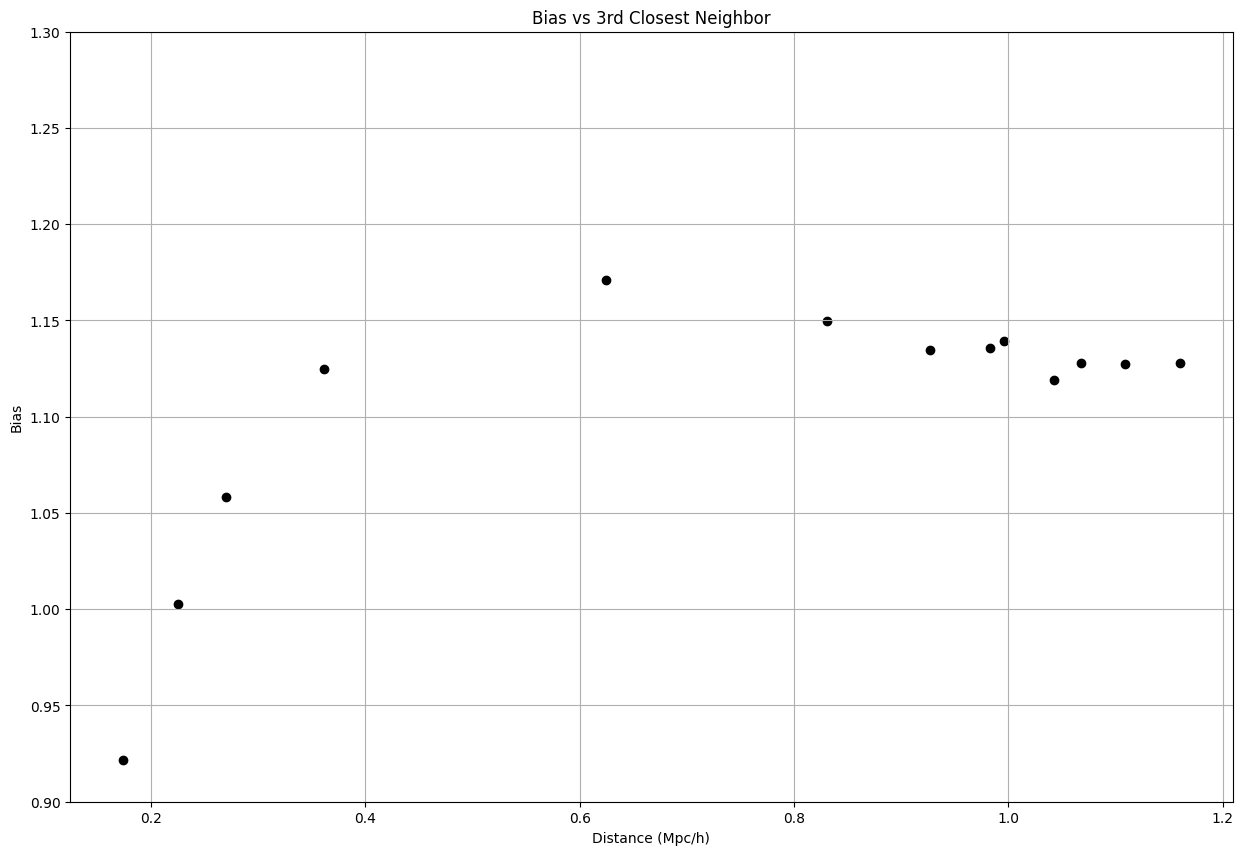

In [253]:
color_list = cm.rainbow(np.linspace(0, 1, threesize))


plt.figure(figsize=(15,10))
for i in range(len(three_b_list)):
    plt.scatter(np.median(three_dist_list[i]),np.median(three_b_list[i]),label=label_list[i],color='black')
#plt.legend()
plt.title('Bias vs 3rd Closest Neighbor')
plt.xlabel('Distance (Mpc/h)')
plt.ylabel('Bias')
plt.ylim(.9,1.3)
plt.grid()
plt.show()

In [189]:
# building luminosity bins
k_mag=galaxycat['K_Mag']

k_mean=k_mag.mean()
k_std=k_mag.std()

k_min=math.floor(k_mag.min())
k_max=math.ceil(k_mag.max())

# bin via half mag
size=(k_max-k_min)*2
col='K_Mag'
low=k_min
high=k_min+.5


three_b_list=[]
three_dist_list=[]
label_list=[]
for i in range(size):
    templabel=str(low)+" - "+str(high)
    tempb,tempdist=distsorter(galaxycat, low, high, "K_Mag", delta_g_smoothed, delta_smoothed)
    three_b_list.append(tempb)
    three_dist_list.append(tempdist)
    label_list.append(templabel)
    low+=.5
    high+=.5

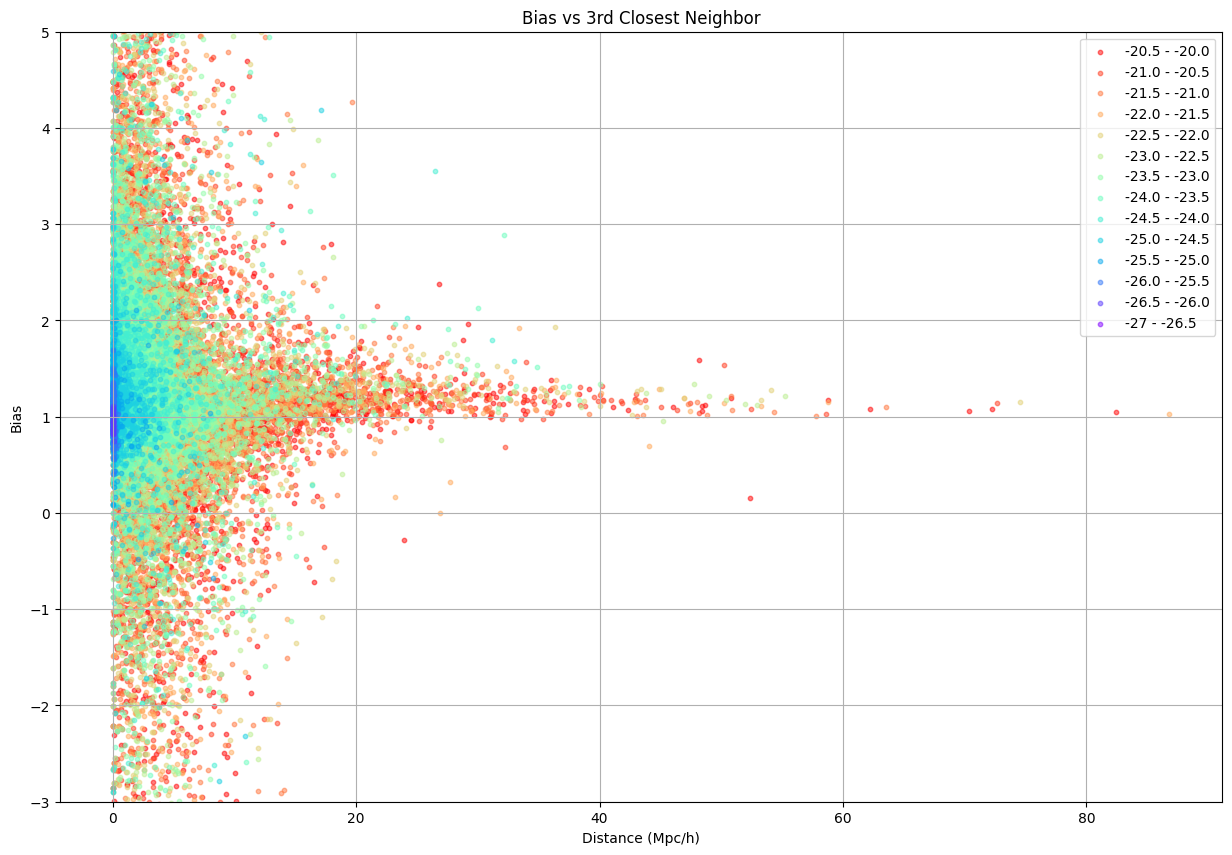

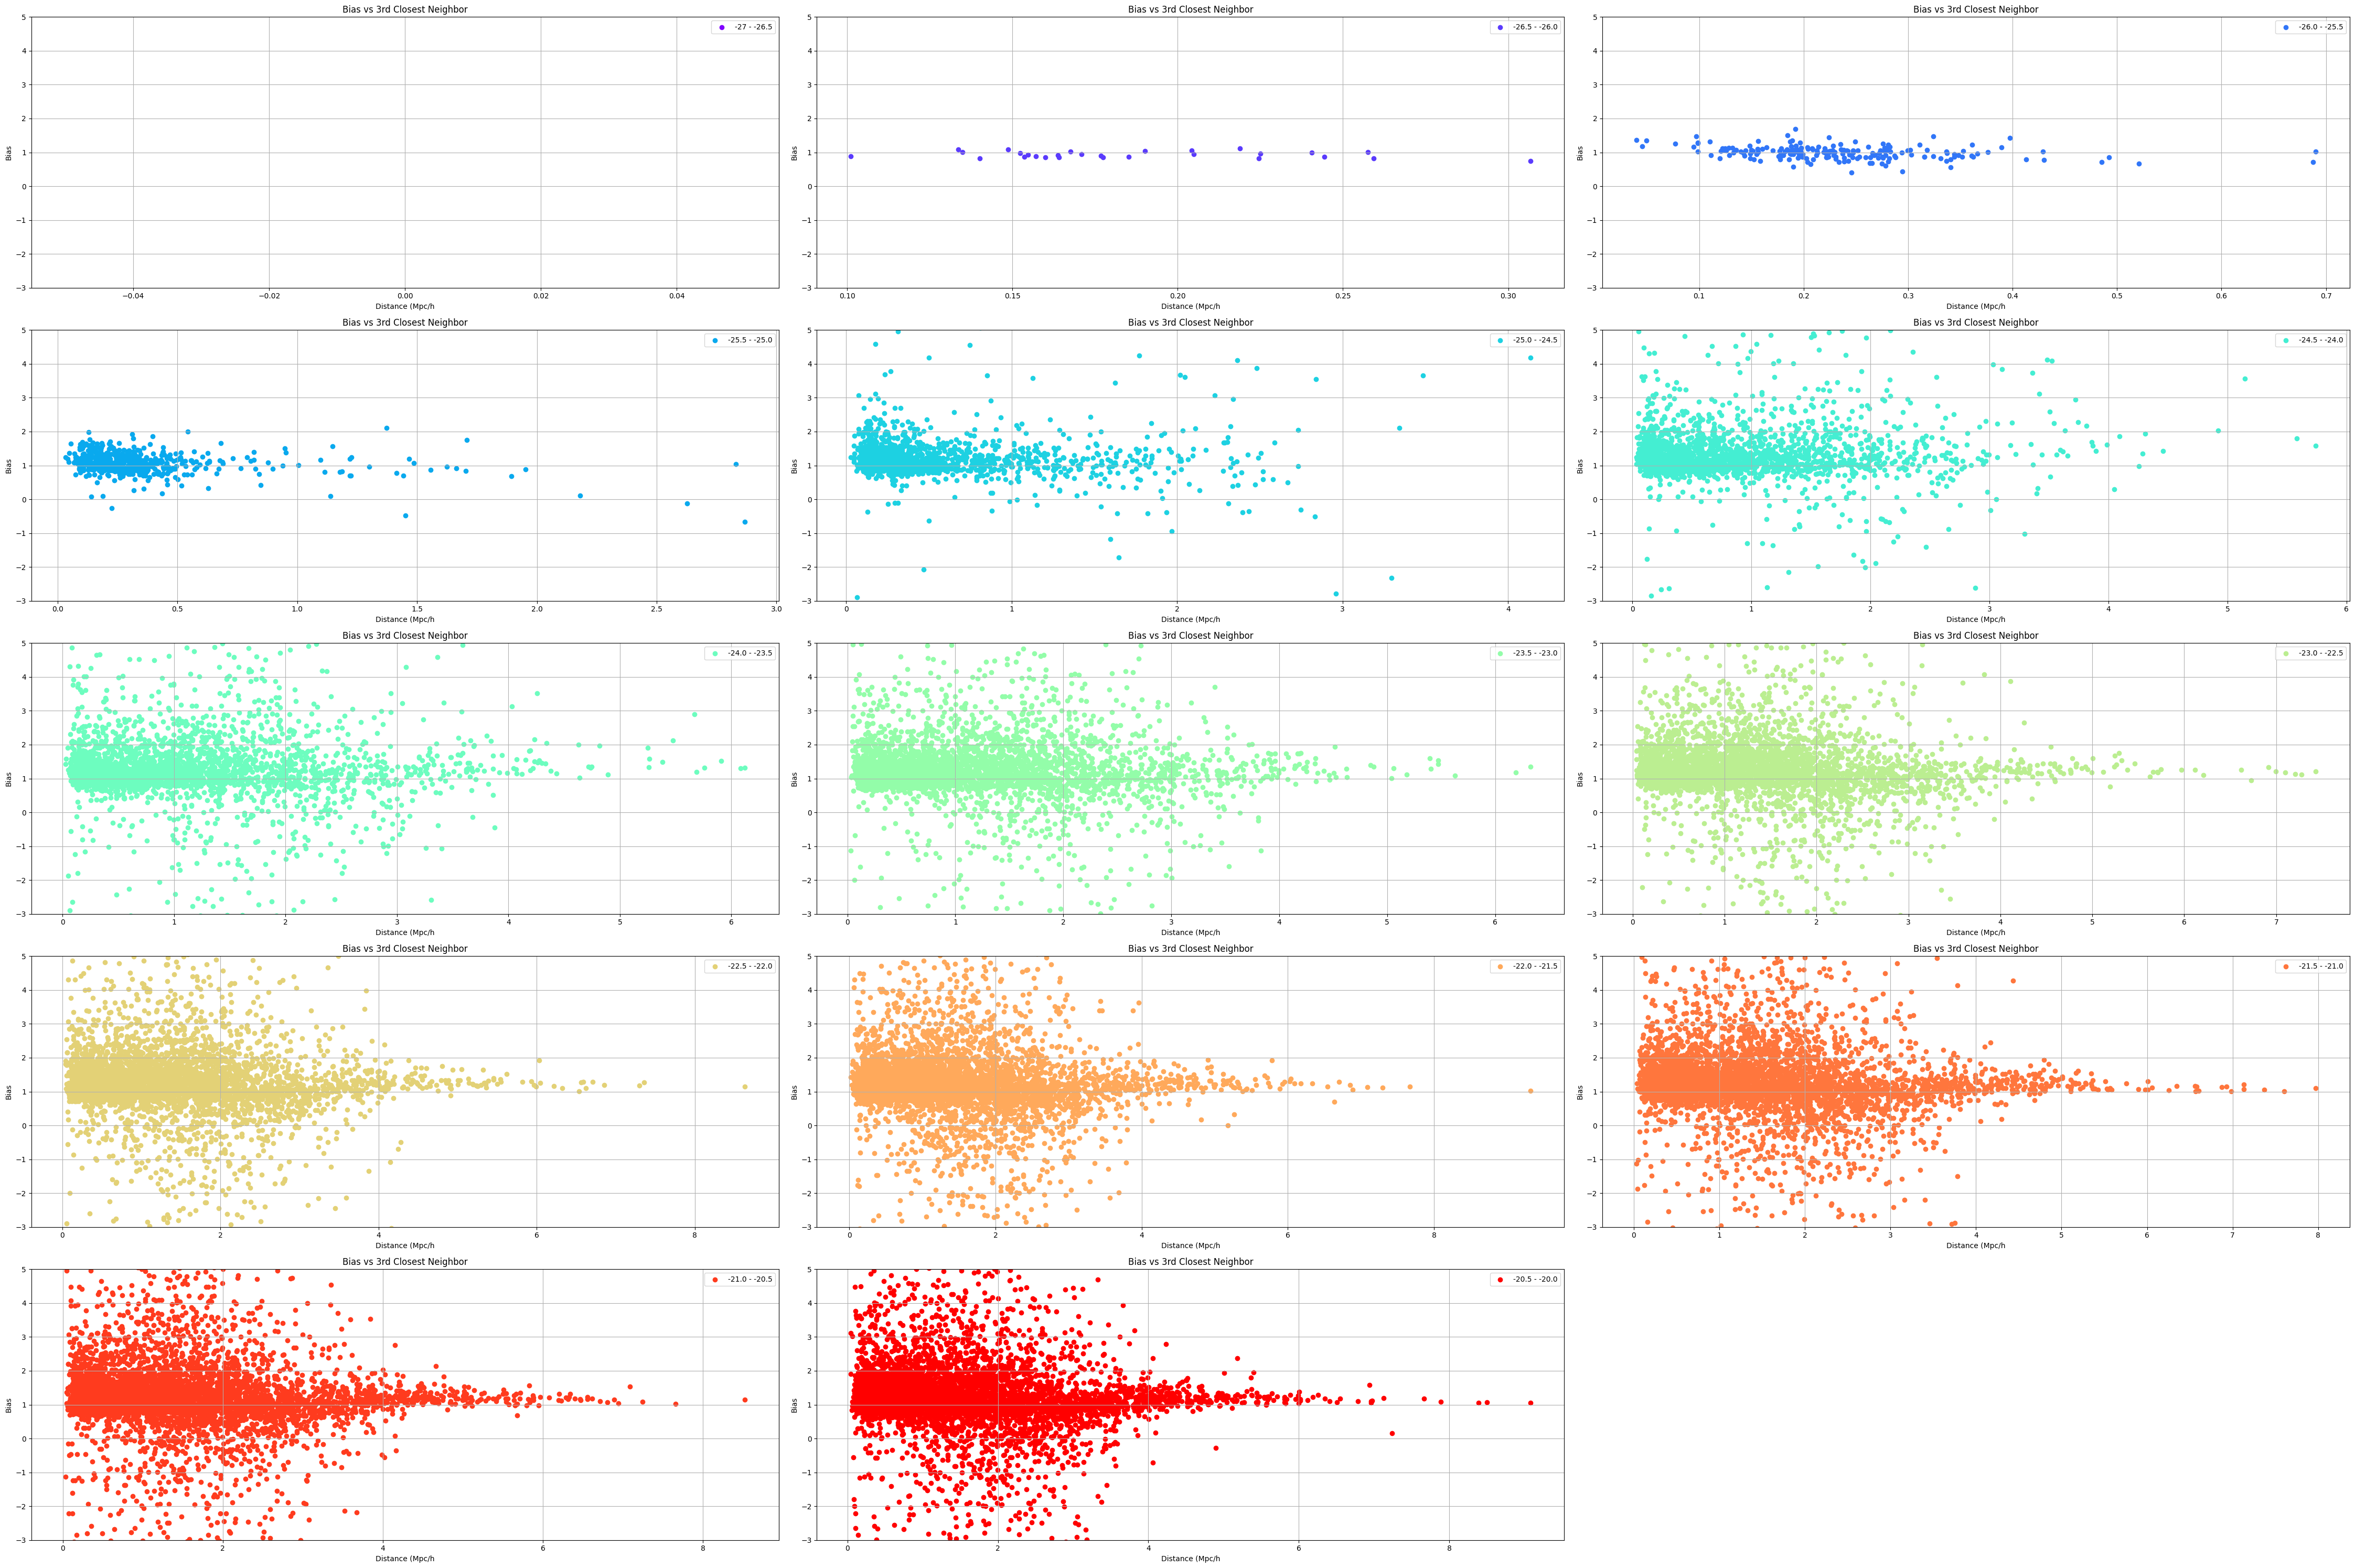

In [248]:
color_list = cm.rainbow(np.linspace(0, 1, size))


plt.figure(figsize=(15,10))
for j in range(len(three_b_list)):
    i=len(three_b_list)-j-1
    plt.scatter(three_dist_list[i]**2 ,three_b_list[i],label=label_list[i],color=color_list[i],alpha=.5,s=10)
plt.legend()
plt.title('Bias vs 3rd Closest Neighbor')
plt.xlabel('Distance (Mpc/h)')
plt.ylabel('Bias')
plt.ylim(-3,5)
plt.grid()
#plt.savefig("Bias_Distmag.png",format="png")
plt.show()

height=math.ceil(size/3)
fig =plt.figure(figsize=(45,30))
for i in range(len(b_list)):
    q,r=inttopair(i,3)
    ax = plt.subplot2grid((height, 3), (q, r), rowspan=1, colspan=1)
    
    hist = ax.scatter(three_dist_list[i],three_b_list[i],label=label_list[i],color=color_list[i])
    ax.legend()
    ax.set_ylim(-3,5)
    ax.title.set_text('Bias vs 3rd Closest Neighbor')
    ax.set_xlabel('Distance (Mpc/h')
    ax.set_ylabel('Bias')
    ax.grid()

#plt.savefig("Bias_Magindmag.png",format="png")
plt.tight_layout()
plt.show()

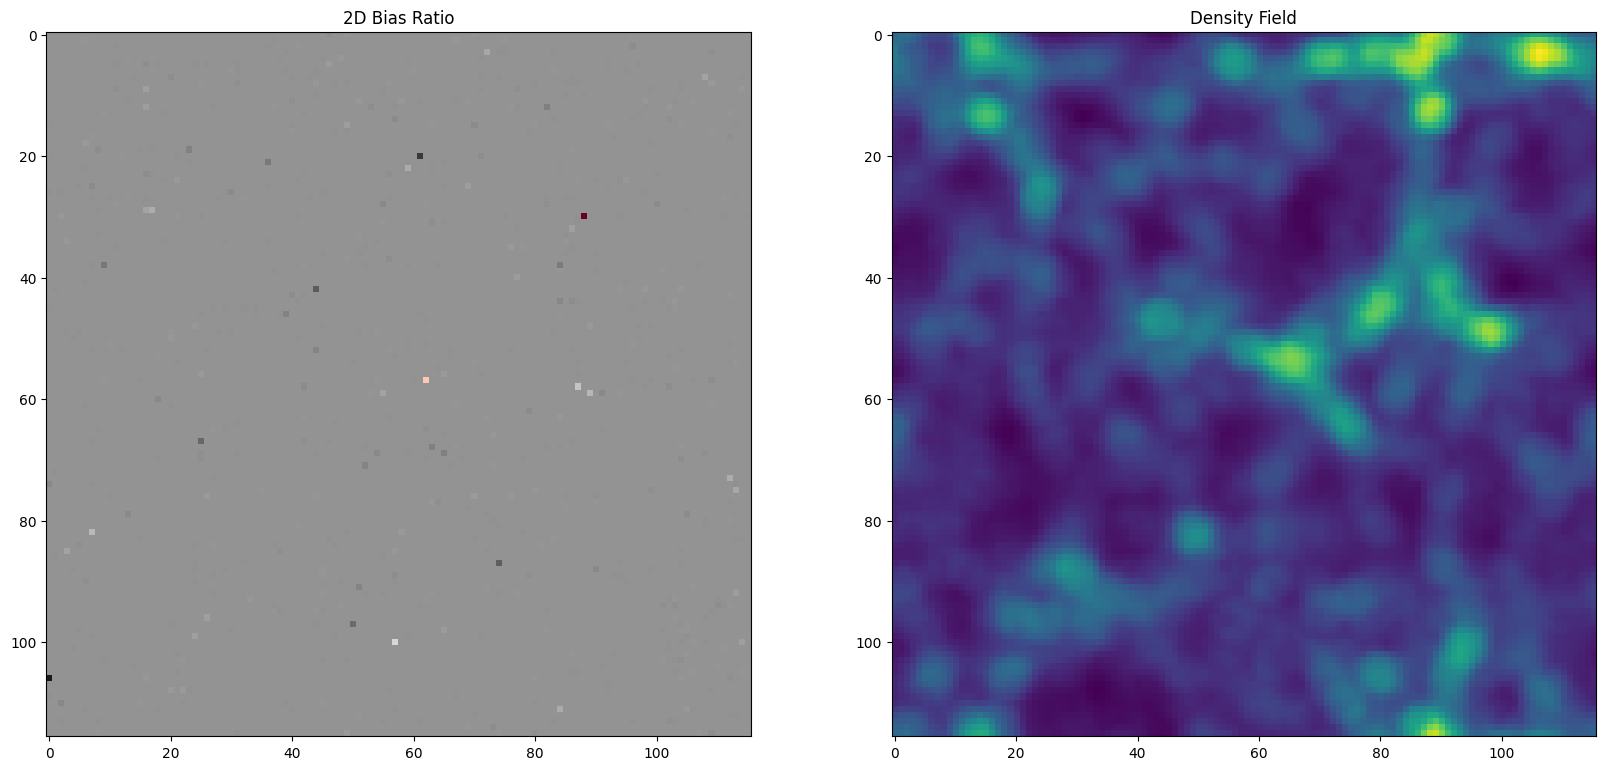

In [256]:
mean_b=np.mean(delta_g_smoothed/delta_smoothed,axis=0)
fig=plt.figure(figsize=(20,10))

ax1 = plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
ax1.imshow(np.mean(delta_g_smoothed/delta_smoothed,axis=0), cmap="RdGy")
ax1.set_title("2D Bias Ratio")

ax2 = plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1)
ax2.imshow(np.mean(delta_g_smoothed,axis=0))
ax2.set_title("Density Field")


#plt.savefig("2dbiasratio+dense.png",format="png")
plt.show()

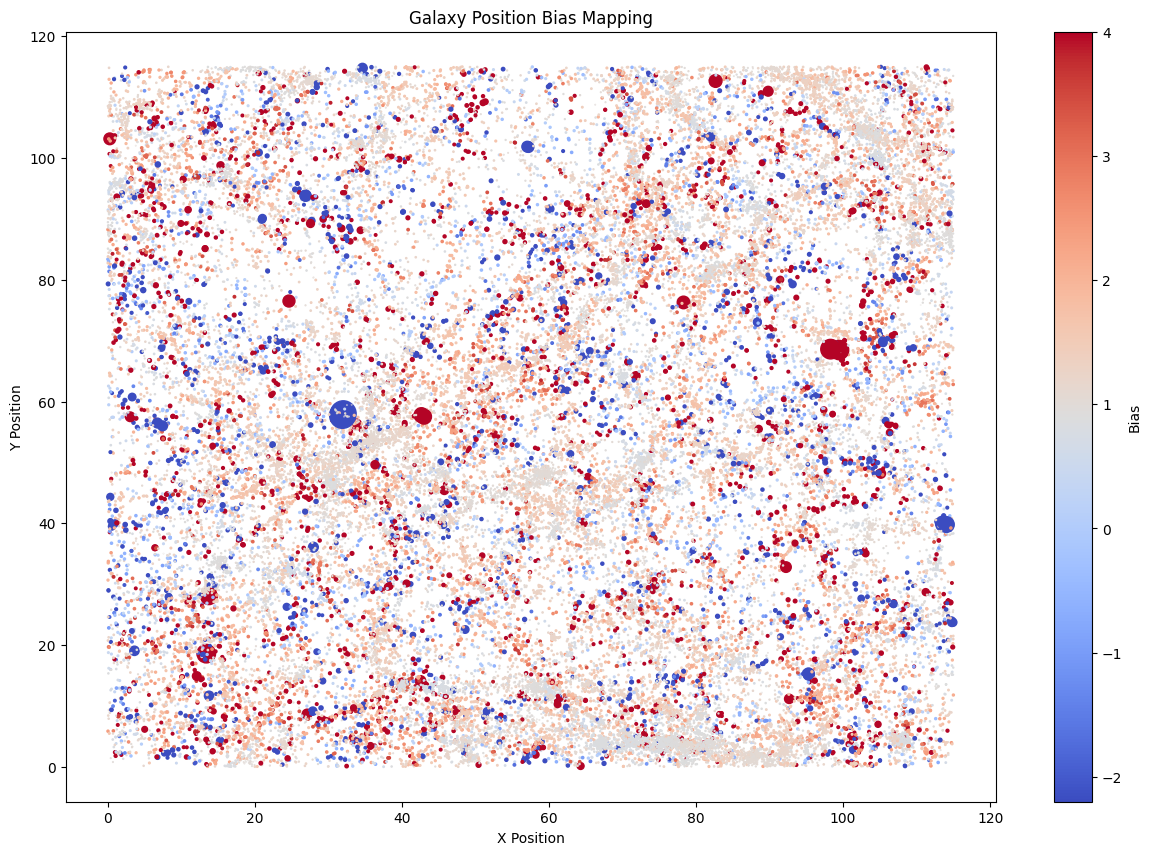

In [282]:
x_pos=galaxycat['x']
y_pos=galaxycat['y']


plt.figure(figsize=(15,10))
plt.scatter(x_pos,y_pos,c=comb_b,vmin=4, vmax=-2,cmap="coolwarm",s=np.sqrt(np.abs(comb_b-1))*2)
plt.colorbar(label='Bias')
plt.title('Galaxy Position Bias Mapping')
plt.xlabel('X Position')
plt.ylabel('Y Position')
#plt.savefig("Galaxymap.png",format="png")
plt.show()